In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

In [5]:
# Read in Data and print data types
df = pd.read_csv('creditcard.csv')

<div style="background-color:green; color:black; padding:10px; border-radius:5px;">
    <h2>Data Schema</h2>
    <p>This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.</p>

<p>It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.</p>  
<p>Source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download</p>
</div>

In [7]:
# Peek at data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Check for Missing Values

In [9]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]


Series([], dtype: int64)

#### No Missing Values Present

#### Examine Distribution of Features

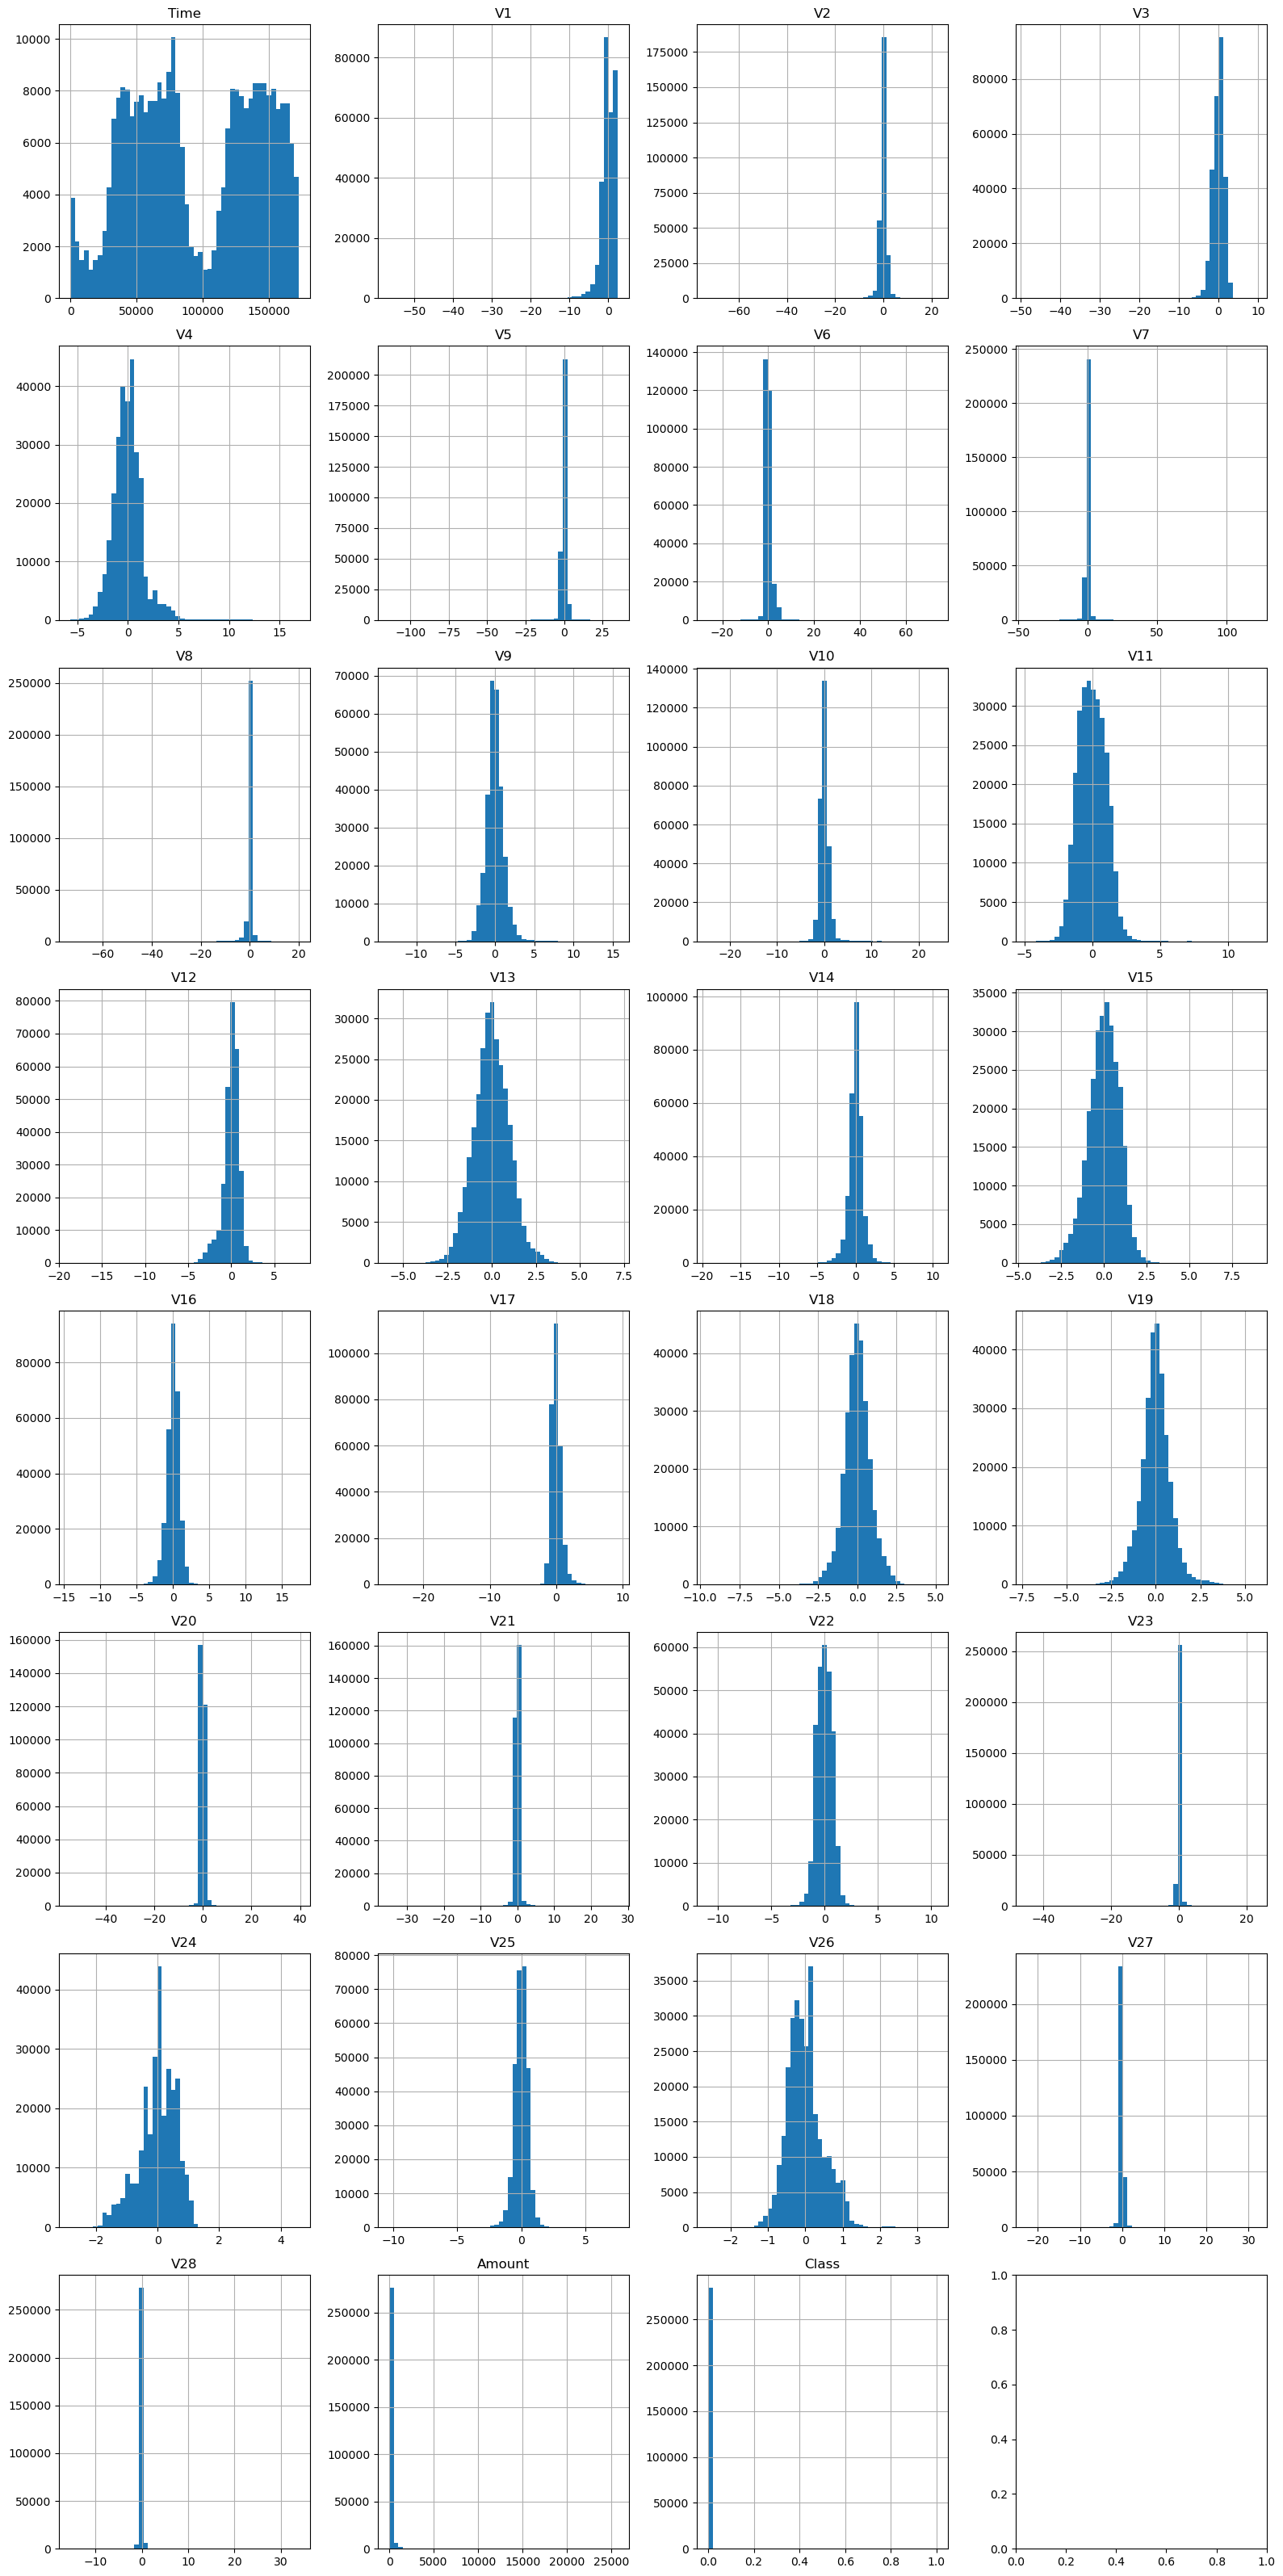

In [11]:
# Define number of columns for subplots
num_features = df.shape[1]  
num_cols = 4
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))
axes = axes.flatten()

# Plot histogram for each feature
for i, column in enumerate(df.columns):  
    df[column].hist(bins=50, ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()


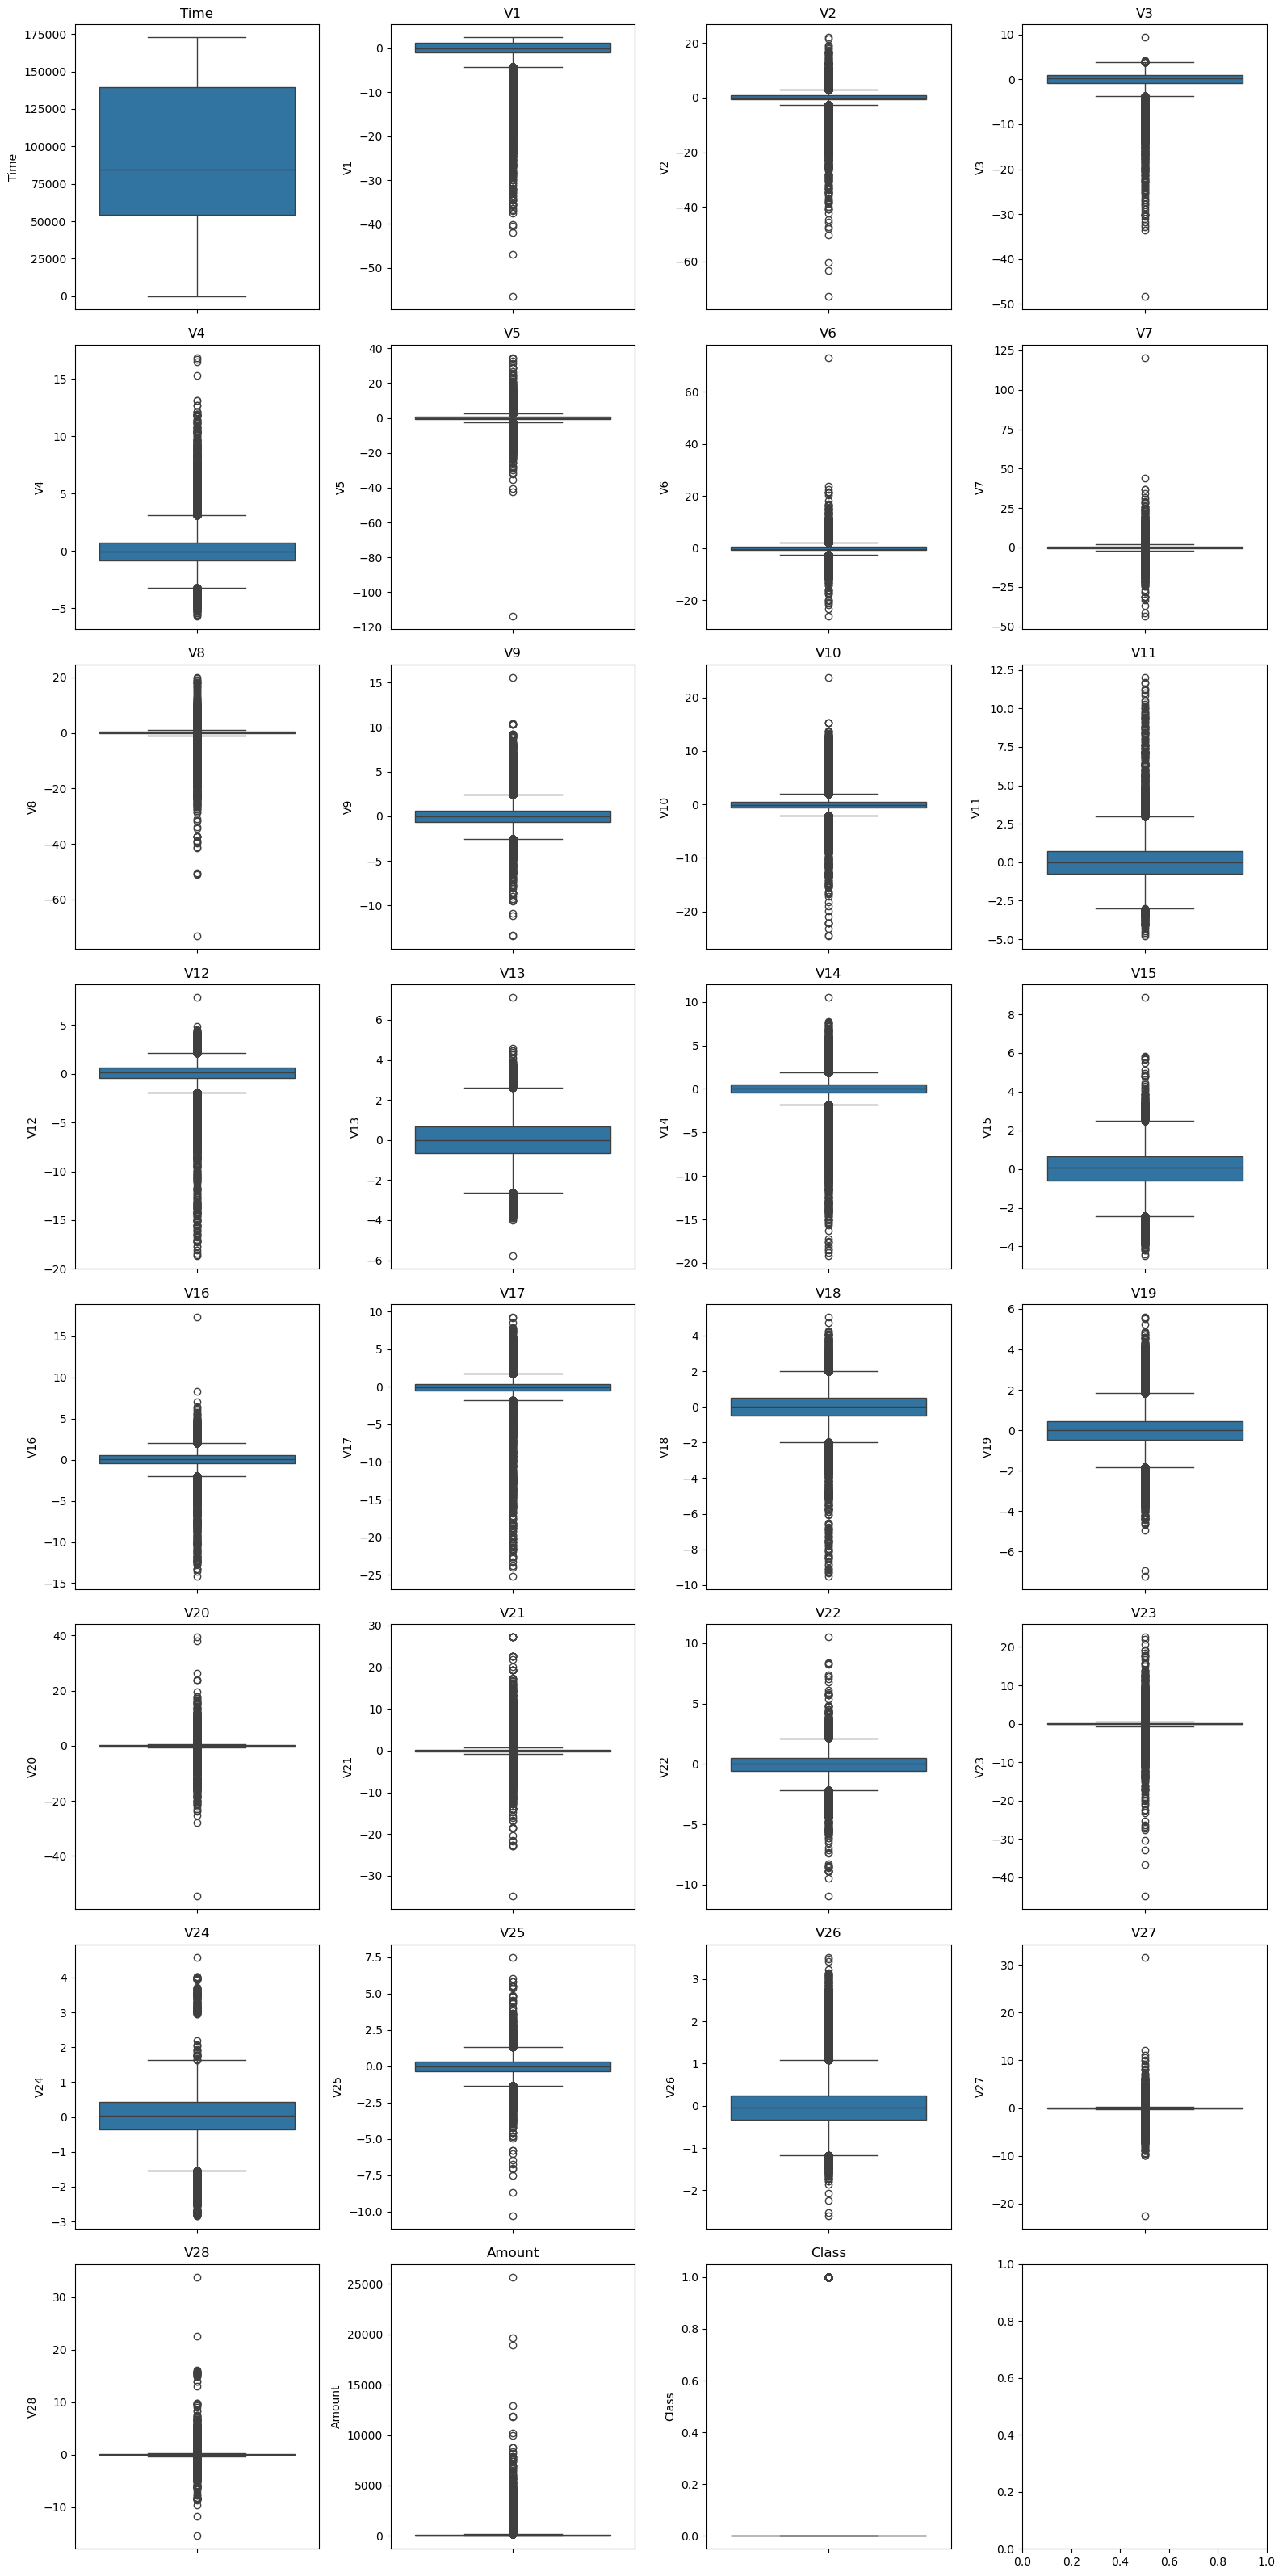

In [13]:
# Define number of columns for subplots
num_features = df.shape[1]  
num_cols = 4
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))
axes = axes.flatten()

# Plot boxplot for each feature
for i, column in enumerate(df.columns):  
    sns.boxplot(y=df[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()


#### TODO:
Examine techniques for handling outliers

#### Check if PCA has Eliminated Correlation Among the Features

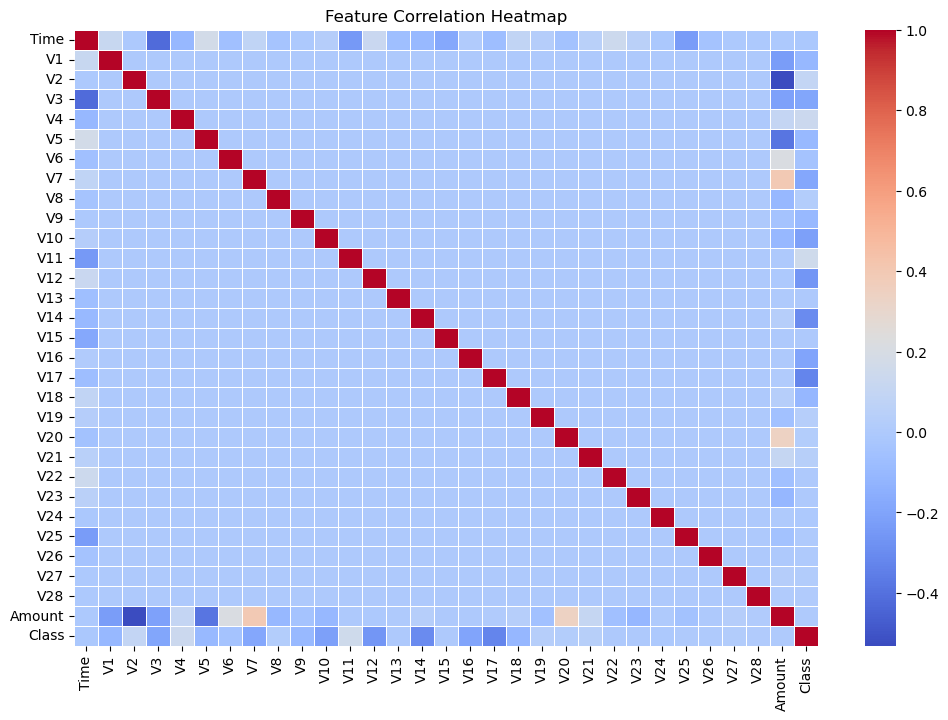

In [16]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()


#### Correaltion Ammong the Features Looks Really Good Due to PCA

#### Do we need scaling?

In [18]:
print(df.describe().T[['mean', 'std', 'min', 'max']])


                mean           std         min            max
Time    9.481386e+04  47488.145955    0.000000  172792.000000
V1      1.168375e-15      1.958696  -56.407510       2.454930
V2      3.416908e-16      1.651309  -72.715728      22.057729
V3     -1.379537e-15      1.516255  -48.325589       9.382558
V4      2.074095e-15      1.415869   -5.683171      16.875344
V5      9.604066e-16      1.380247 -113.743307      34.801666
V6      1.487313e-15      1.332271  -26.160506      73.301626
V7     -5.556467e-16      1.237094  -43.557242     120.589494
V8      1.213481e-16      1.194353  -73.216718      20.007208
V9     -2.406331e-15      1.098632  -13.434066      15.594995
V10     2.239053e-15      1.088850  -24.588262      23.745136
V11     1.673327e-15      1.020713   -4.797473      12.018913
V12    -1.247012e-15      0.999201  -18.683715       7.848392
V13     8.190001e-16      0.995274   -5.791881       7.126883
V14     1.207294e-15      0.958596  -19.214325      10.526766
V15     

#### PCA Features (V1–V28)  
The mean of these features is approximately 0, and the standard deviation is close to 1, indicating they are already standardized through PCA. Further scaling is not necessary for these features.

#### Time Feature  
The mean = 94,813 and std = 47,488, spanning from 0 to 172,792. Since time has a large range and does not follow a normalized distribution, scaling can help. Recommended: MinMaxScaler (range [0,1]) or StandardScaler for better feature consistency.

#### Amount Feature  
The mean = 88.35, std = 250.12, with a max = 25,691, indicating high variability. Scaling is highly recommended to prevent models from over-weighting the amount. Recommended: Log Transformation (for skewness reduction) + StandardScaler or MinMaxScaler.

#### Perform Scaling on Time And Amount

In [20]:
# Scale Time
time_scaler = MinMaxScaler()
df['Time_scaled'] = time_scaler.fit_transform(df[['Time']])

# Scale Amount
# Log transform first to reduce skewness
df['Amount_log'] = np.log1p(df['Amount'])

# Then apply Standard Scaling
amount_scaler = StandardScaler()
df['Amount_scaled'] = amount_scaler.fit_transform(df[['Amount_log']])

# Drop original Amount column (optional)
df.drop(columns=['Time', 'Amount', 'Amount_log'], inplace=True)

#### Visualize Time Scaled Distribution

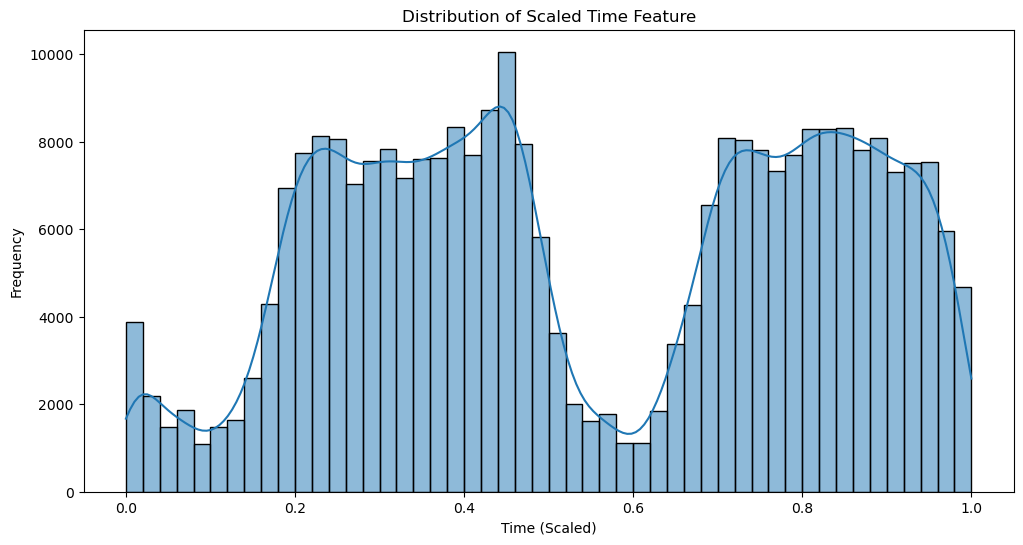

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Time_scaled'], bins=50, kde=True)
plt.title("Distribution of Scaled Time Feature")
plt.xlabel("Time (Scaled)")
plt.ylabel("Frequency")
plt.show()


#### Visualize Amount Scaled Distribution

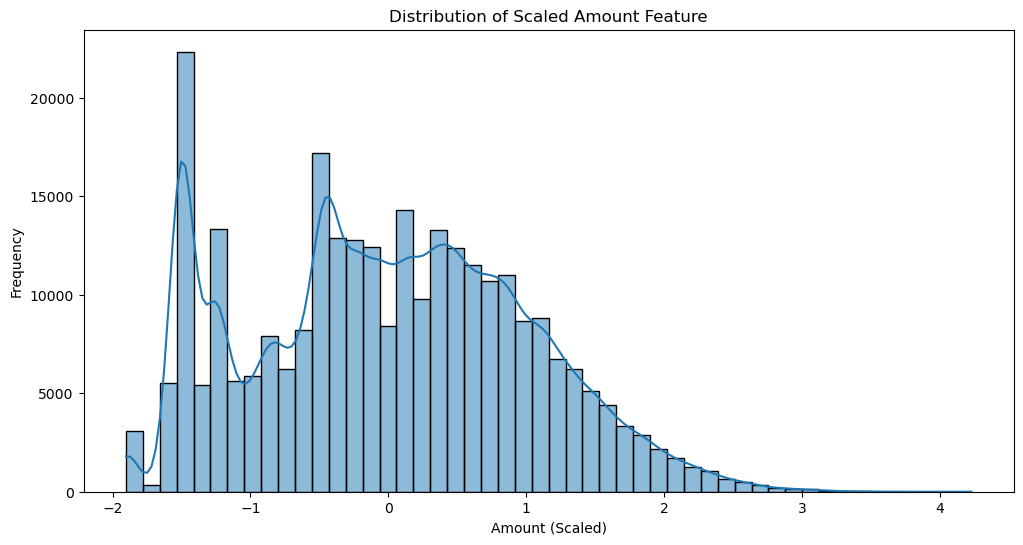

In [24]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Amount_scaled'], bins=50, kde=True)
plt.title("Distribution of Scaled Amount Feature")
plt.xlabel("Amount (Scaled)")
plt.ylabel("Frequency")
plt.show()


#### Identify Temporal Trends

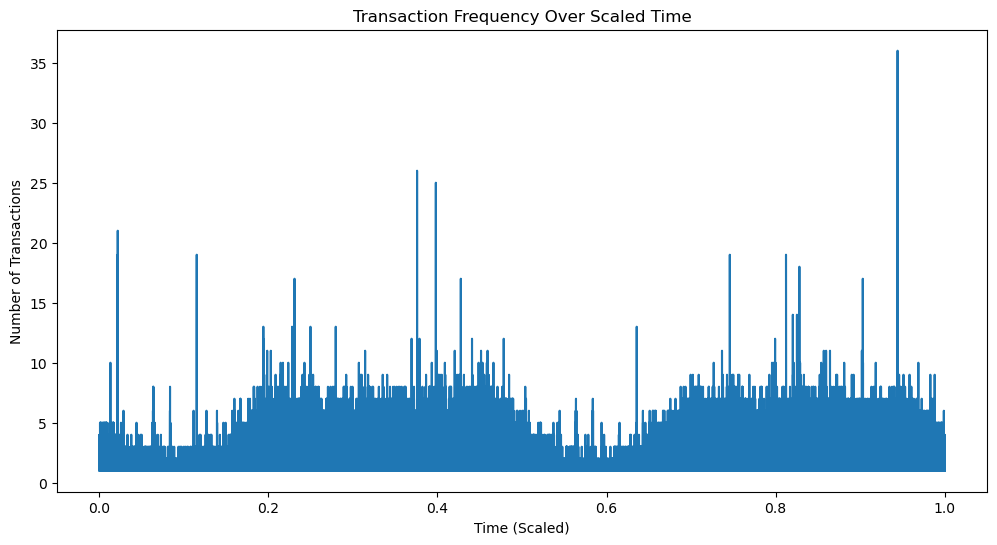

In [26]:
plt.figure(figsize=(12, 6))
df.groupby('Time_scaled').size().plot()
plt.title("Transaction Frequency Over Scaled Time")
plt.xlabel("Time (Scaled)")
plt.ylabel("Number of Transactions")
plt.show()


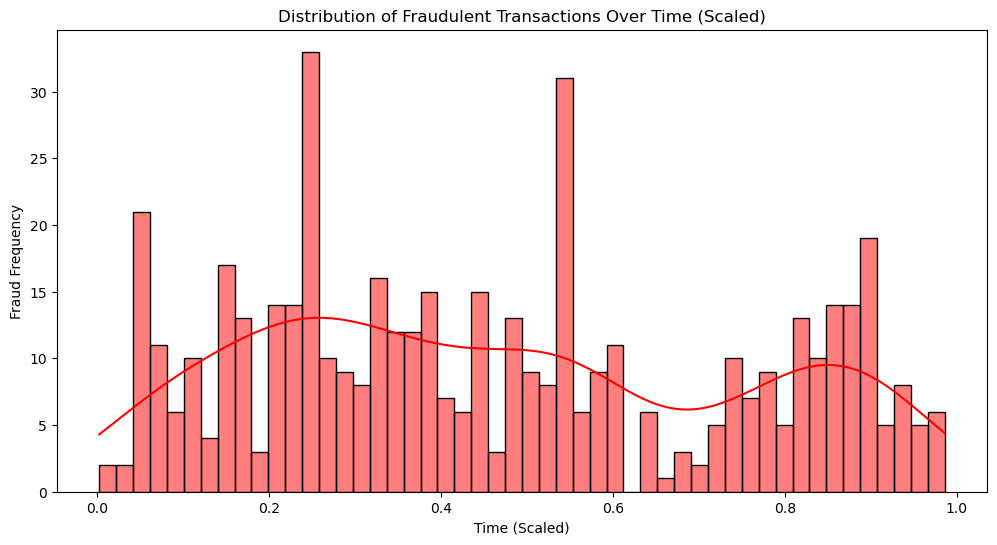

In [28]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['Class'] == 1]['Time_scaled'], bins=50, kde=True, color='red')
plt.title("Distribution of Fraudulent Transactions Over Time (Scaled)")
plt.xlabel("Time (Scaled)")
plt.ylabel("Fraud Frequency")
plt.show()


#### Convert Time Into Cyclical Features for Trend Analysis  
Since fraud patterns might follow a daily cycle, encoding sine and cosine transformations can help machine learning models detect periodic behavior

In [30]:
df['Hour'] = (df['Time_scaled'] * 24).astype(int) % 24
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)


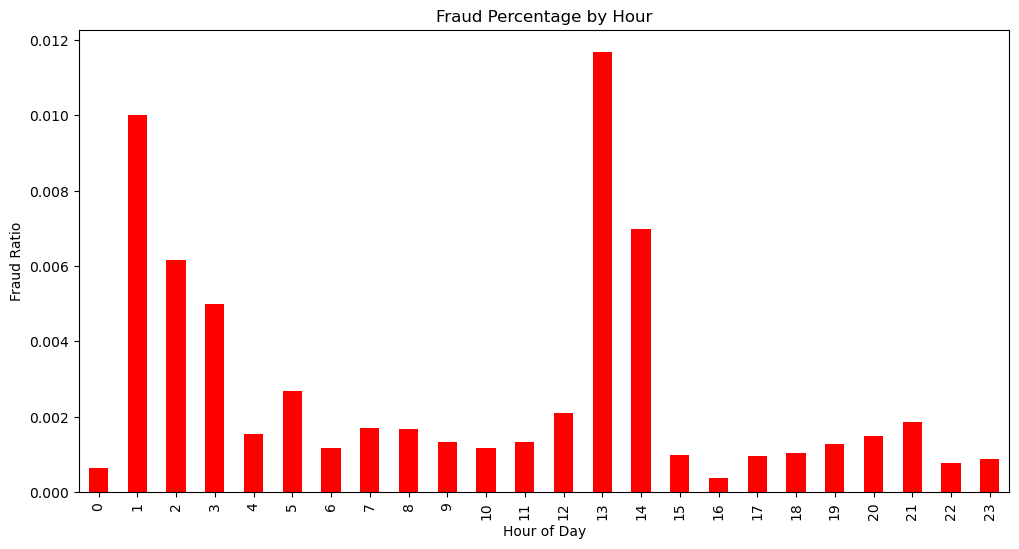

In [32]:
# Compute fraud percentage per hour
fraud_by_hour = df.groupby('Hour')['Class'].mean()

# Plot fraud ratio by hour
plt.figure(figsize=(12, 6))
fraud_by_hour.plot(kind='bar', color='red')
plt.title("Fraud Percentage by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Fraud Ratio")
plt.show()


In [34]:
# Check class distribution
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

# Display results
print("Class Distribution:")
print(class_counts)
print("\nClass Percentages:")
print(class_percentages)


Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Class Percentages:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


#### Resample with SMOTE

In [36]:
# Separate features and target
X = df.drop(columns=['Class'])
y = df['Class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", y_train_resampled.value_counts())


C:\Users\becky\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\becky\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\becky\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\becky\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as pro

Original class distribution:
 Class
0    199020
1       344
Name: count, dtype: int64
Resampled class distribution:
 Class
0    199020
1    199020
Name: count, dtype: int64


#### Baseline model (Logistics Regression)

In [38]:
# Initialize and train Logistic Regression model
log_reg = LogisticRegression(random_state=42, C=0.01, solver='lbfgs', max_iter=1000)
log_reg.fit(X_train_resampled, y_train_resampled)



# Make predictions on test set
y_pred = log_reg.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Accuracy: 0.9768617674941189
Precision: 0.060969755160825735
Recall: 0.8581081081081081
F1 Score: 0.11385029134917078


#### Results  
The 'lbfgs' solver results show a high accuracy (98%), but the low precision (7%) and high recall (84%) indicate an imbalance: the model detects most fraudulent transactions but generates many false positives. This is common when using SMOTE, as it increases the minority class instances but can affect precision.

#### Adjust the Decision Threshold of the Model to Improve Precsion Without Losing Recall  
The default logistic regression threshold is 0.5, but lowering it might improve precision

In [42]:
y_probs = log_reg.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Adjust the threshold to improve precision (probability of classification of fraud - default > 0.5)
best_threshold = thresholds[np.argmax(precisions[:-1])]  # Avoid last precision entry without a threshold
y_pred_adjusted = (y_probs >= best_threshold).astype(int)



In [44]:
print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.64      0.74       148

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



#### **Classification Report Analysis**

#### **Class-wise Breakdown**
| Metric       | Class 0 (Non-Fraud) | Class 1 (Fraud) |
|-------------|-------------------|----------------|
| **Precision** | 1.00 | 0.88 |
| **Recall**    | 1.00 | 0.64 |
| **F1-score**  | 1.00 | 0.74 |
| **Support**   | 85,295 | 148 |

#### **Class 0: Non-Fraudulent Transactions**
- **Precision (1.00)** → Every predicted non-fraud case was **correctly classified** (no false positives).
- **Recall (1.00)** → All actual non-fraud cases were detected (no false negatives).
- **F1-score (1.00)** → Perfect balance between precision and recall.
- **Support (85,295)** → The dataset contains **85,295 legitimate transactions**.

#### **Class 1: Fraudulent Transactions**
- **Precision (0.88)** → When the model predicted fraud, it was correct **88% of the time**. This means **12% of fraud predictions were false positives** (legitimate transactions misclassified as fraud).
- **Recall (0.64)** → The model correctly identified **64% of actual fraud cases**, but **missed 36%**, meaning some fraudulent transactions went undetected.
- **F1-score (0.74)** → A balance between precision and recall. It’s **decent**, but suggests room for improvement in recall.
- **Support (148)** → Only **148 fraud transactions** were present in the dataset, showing heavy class imbalance.

#### **Overall Model Performance**
| Metric        | Score |
|--------------|------|
| **Accuracy**   | 1.00 |
| **Macro Avg**  | Precision: 0.94, Recall: 0.82, F1-score: 0.87 |
| **Weighted Avg** | Precision: 1.00, Recall: 1.00, F1-score: 1.00 |

#### **Key Takeaways**
- **High Precision but Lower Recall for Fraud Cases** → The model avoids too many false fraud alarms, but **misses some actual fraud cases**.
- **Potential Next Steps** → If catching fraud is more critical, consider:
  - **Adjusting the decision threshold**
  - **Trying different sampling techniques** (e.g., combining under-sampling with SMOTE)
  - **Switching to tree-based models** (e.g., Random Forests, XGBoost) for better handling of imbalanced data.



#### Fine-tune the decision threshold

In [46]:
# Get model probabilities
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Select threshold for highest F1-score (balanced precision & recall)
best_threshold = thresholds[np.argmax(2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1]))]

# Apply new threshold
y_pred_adjusted = (y_probs >= best_threshold).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_adjusted))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.85      0.79      0.82       148

    accuracy                           1.00     85443
   macro avg       0.92      0.90      0.91     85443
weighted avg       1.00      1.00      1.00     85443



#### **Comparison of Model Performance Before and After Adjusting the Decision Threshold**

#### **Class-wise Breakdown (Fraudulent Transactions - Class 1)**
| Metric       | Before Adjustment | After Adjustment | Difference |
|-------------|------------------|------------------|------------|
| **Precision**  | 0.88 | 0.85 | ↓ Slight drop (-0.03) |
| **Recall**     | 0.64 | 0.79 | ↑ Significant increase (+0.15) |
| **F1-score**   | 0.74 | 0.82 | ↑ Better balance (+0.08) |
| **Support**    | 148  | 148  | No change |

##### **Observations**
- **Precision dropped slightly (0.88 → 0.85)**  
  → Lowering the threshold **allows more fraud predictions**, but slightly increased false positives.
- **Recall improved significantly (0.64 → 0.79)**  
  → The model **now detects more actual fraud cases**, reducing false negatives.
- **F1-score improved (0.74 → 0.82)**  
  → Indicates a better balance between precision and recall, making fraud detection more reliable.

---

#### **Overall Model Impact**
| Metric        | Before Adjustment | After Adjustment | Difference |
|--------------|------------------|------------------|------------|
| **Macro Avg Precision** | 0.94 | 0.92 | ↓ (-0.02) |
| **Macro Avg Recall**    | 0.82 | 0.90 | ↑ (+0.08) |
| **Macro Avg F1-score**  | 0.87 | 0.91 | ↑ (+0.04) |

#### **Takeaways**
- **Macro average recall improved**, indicating better fraud detection.
- **Weighted averages remained perfect (1.00) due to the dominance of non-fraud cases**, which skews these metrics.

#### **Conclusion**
Adjusting the threshold **successfully improved recall**, meaning the model **catches more fraudulent transactions**. While precision dropped slightly, this trade-off is beneficial if reducing fraud cases is a priority.

# SVM and DT Model Pipeline

## Train-Test Split with Stratification

In [48]:
from sklearn.model_selection import train_test_split

# Define features and labels
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

## Handling Imbalance with SMOTE

In [50]:
import os
import warnings
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.utils.validation import validate_data

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, 
                       message="Could not find the number of physical cores")

# Set environment variable to specify CPU count (adjust to your actual core count)
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Set this to your number of CPU cores

# Now apply SMOTE to balance the training data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Check the resampled class distribution
print("Resampled class distribution:")
print(pd.Series(y_train_res).value_counts())



Resampled class distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


##  Feature Engineering with PCA

In [52]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions 
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_res)
X_test_pca = pca.transform(X_test)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Explained variance ratio: [0.62101158 0.12077576 0.08272812 0.05801291 0.03171304 0.02242952
 0.00861549 0.00629344 0.00581791 0.005131  ]


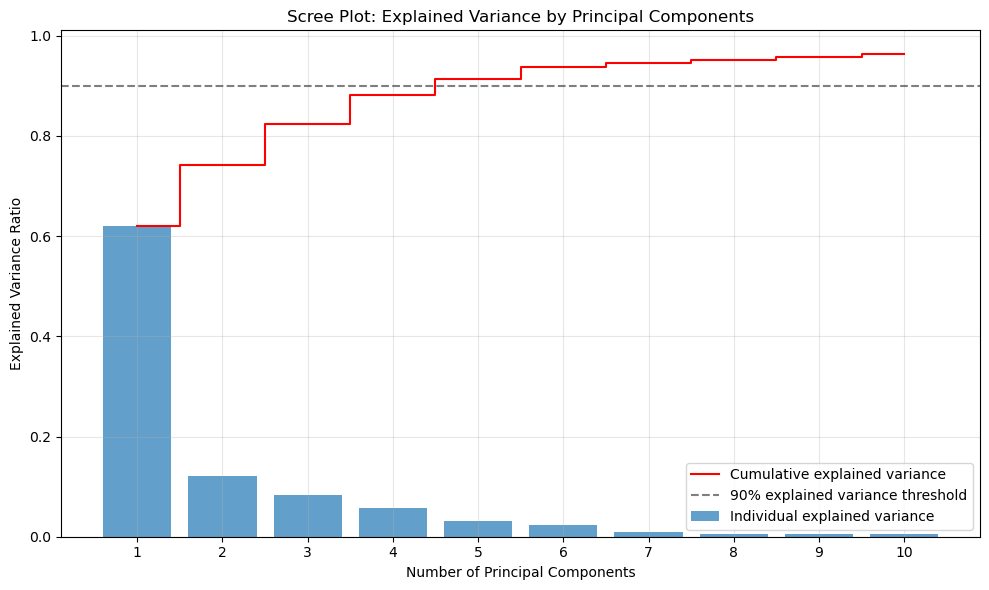

In [54]:
# Add a Screen plot to visualize explained variance
import matplotlib.pyplot as plt
import numpy as np

# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot individual explained variance
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_, 
        alpha=0.7, 
        label='Individual explained variance')

# Plot cumulative explained variance
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         where='mid', 
         label='Cumulative explained variance', 
         color='red')

# Add horizontal line at 90% explained variance
plt.axhline(y=0.9, color='k', linestyle='--', alpha=0.5, label='90% explained variance threshold')

# Customize the plot
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot: Explained Variance by Principal Components')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

- The first component alone captures a large portion of the variance, suggesting that data has a strong primary direction of variation.
- There's a significant drop between the first and second components (70.05% to 9.64%), indicating that the first component is substantially more important than the others.


## Decision Tree Model Training and Evaluation

In [56]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger('dt_training')


# Train Decision Tree model with balanced class weights
logger.info("Starting Decision Tree model training...")
start_time = time.time()

dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Log parameters
logger.info(f"Model parameters: class_weight='balanced', random_state=42")

# Fit model with logging
logger.info(f"Training on {X_train_res.shape[0]} samples with {X_train_res.shape[1]} features")
dt_model.fit(X_train_res, y_train_res)

# Log training completion and tree structure
training_time = time.time() - start_time
logger.info(f"Training completed in {training_time:.2f} seconds")
logger.info(f"Tree depth: {dt_model.get_depth()}, Number of nodes: {dt_model.tree_.node_count}")

# Log prediction process
logger.info(f"Making predictions on {X_test.shape[0]} test samples")
y_pred_dt = dt_model.predict(X_test)

# Log basic performance
accuracy = accuracy_score(y_test, y_pred_dt)
logger.info(f"Test accuracy: {accuracy:.4f}")
logger.info("Decision Tree model processing completed")

2025-06-13 12:10:36,184 - INFO - Starting Decision Tree model training...
2025-06-13 12:10:36,186 - INFO - Model parameters: class_weight='balanced', random_state=42
2025-06-13 12:10:36,189 - INFO - Training on 454902 samples with 33 features
2025-06-13 12:12:11,523 - INFO - Training completed in 95.34 seconds
2025-06-13 12:12:11,523 - INFO - Tree depth: 44, Number of nodes: 1593
2025-06-13 12:12:11,523 - INFO - Making predictions on 56962 test samples
2025-06-13 12:12:11,561 - INFO - Test accuracy: 0.9975
2025-06-13 12:12:11,562 - INFO - Decision Tree model processing completed


In [58]:
## Calculate evaluation of Decision Tree 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt, average='weighted')
recall = recall_score(y_test, y_pred_dt, average='weighted')
f1 = f1_score(y_test, y_pred_dt, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Accuracy: 0.9975
Precision: 0.9986
Recall: 0.9975
F1 Score: 0.9979

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.78      0.52        98

    accuracy                           1.00     56962
   macro avg       0.69      0.89      0.76     56962
weighted avg       1.00      1.00      1.00     56962



2025-06-13 12:12:45,958 - INFO - Creating Decision Tree visualizations...
2025-06-13 12:12:51,398 - INFO - Visualization saved as 'decision_tree_analysis.png'


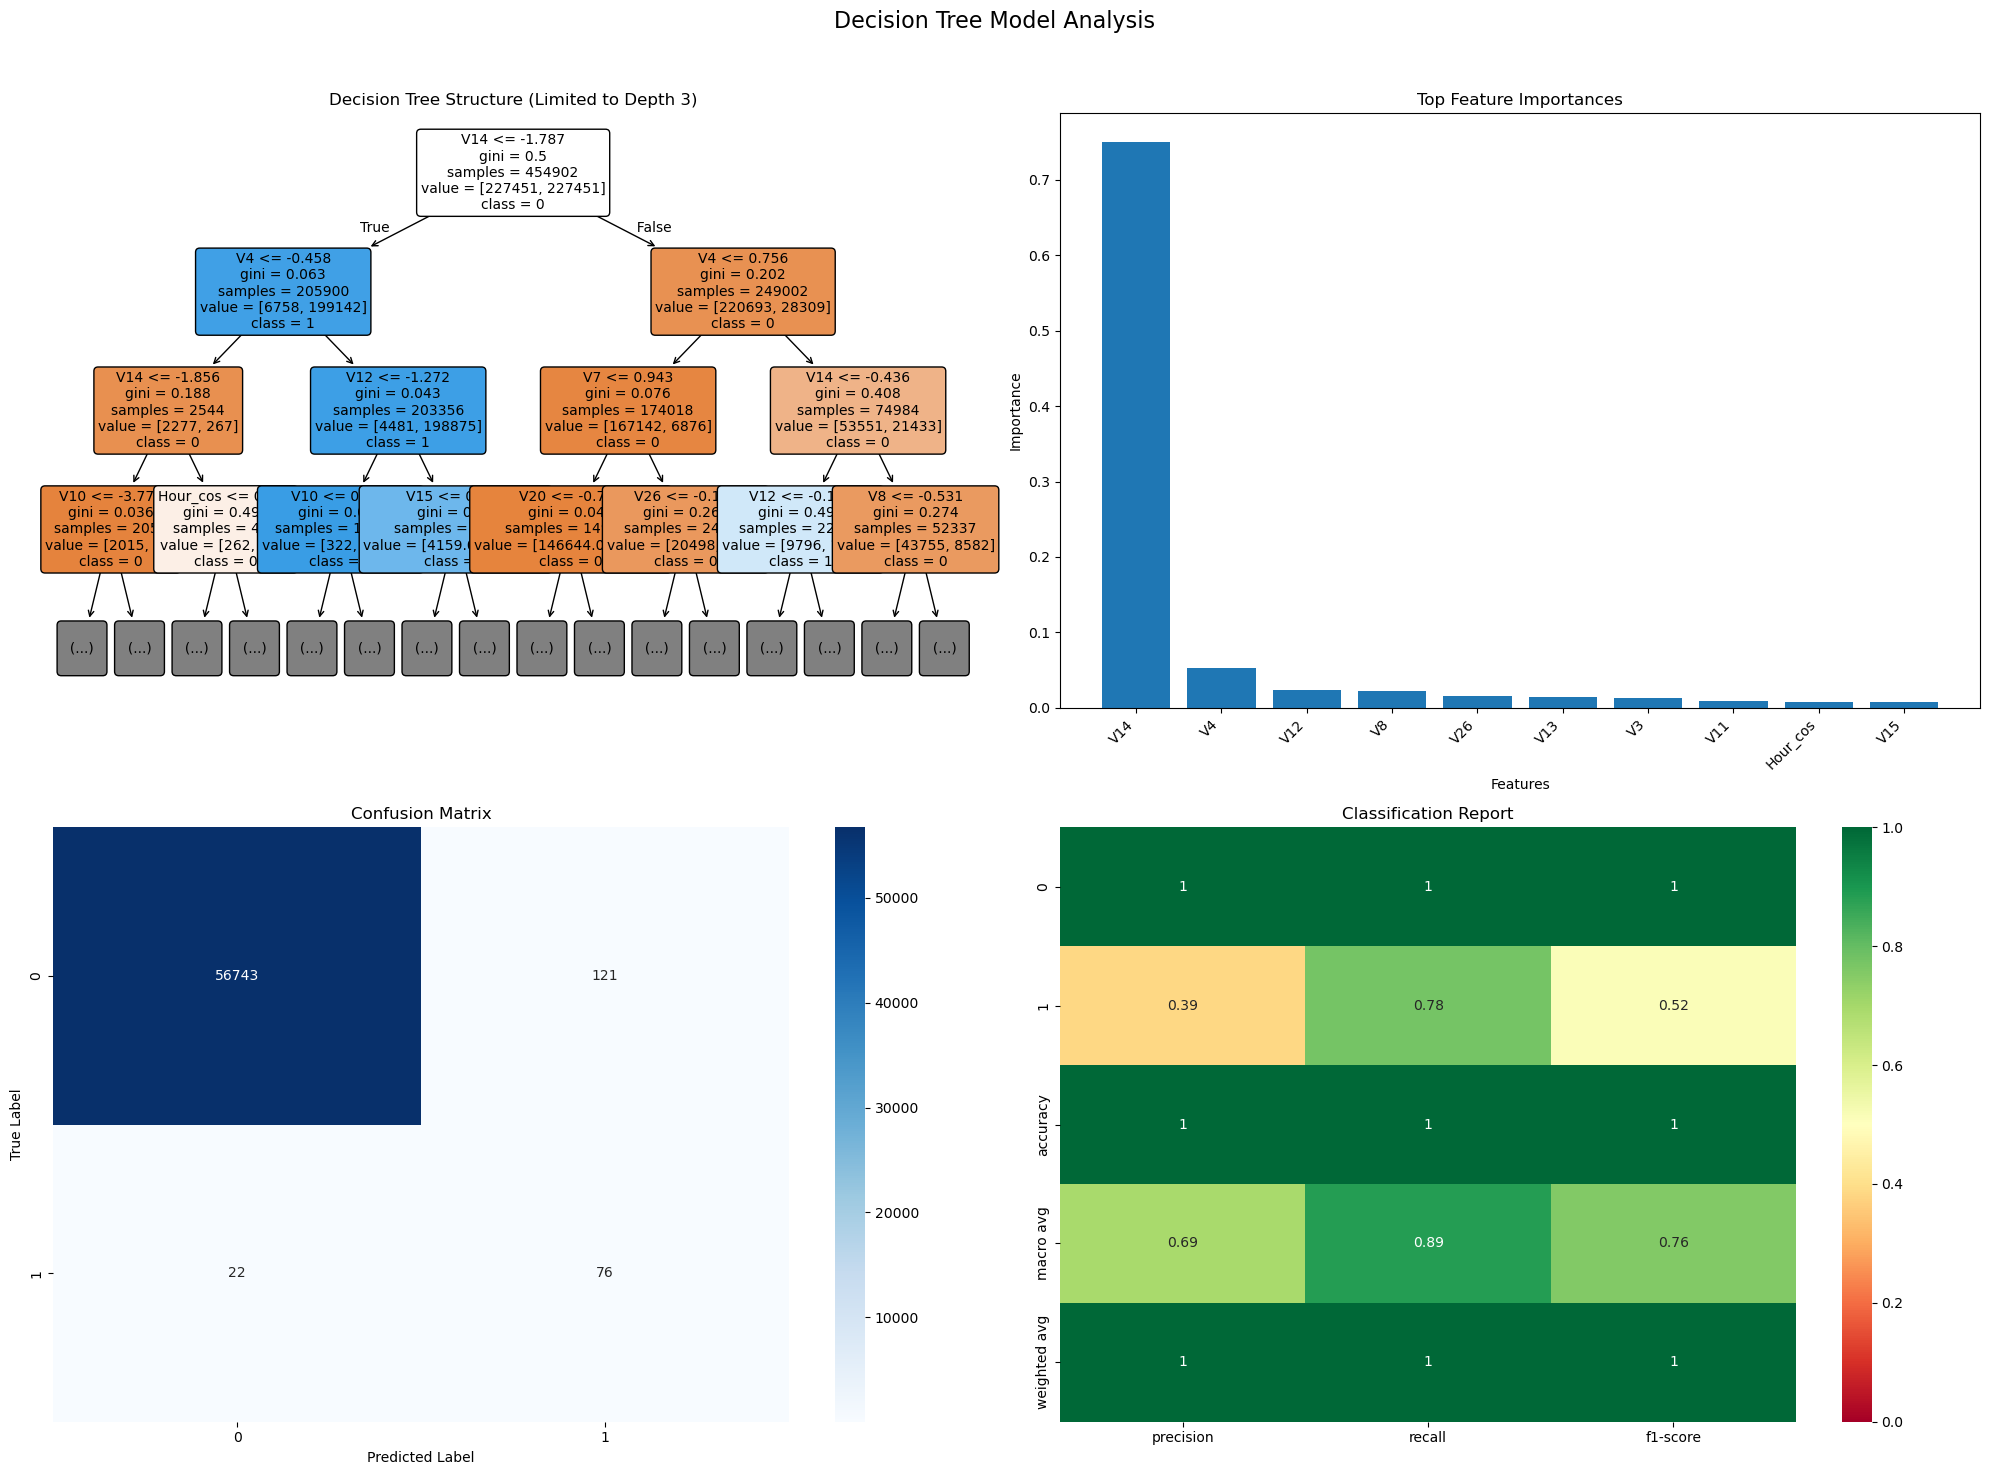

In [60]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ---- VISUALIZATION CODE ----
logger.info("Creating Decision Tree visualizations...")

# Create a figure with multiple subplots for different visualizations
plt.figure(figsize=(20, 15))

# 1. Tree Structure Visualization
plt.subplot(2, 2, 1)
# Try to get feature names, or use indices if not available
try:
    feature_names = X_train_res.columns.tolist() if hasattr(X_train_res, 'columns') else [f"feature_{i}" for i in range(X_train_res.shape[1])]
except:
    feature_names = [f"feature_{i}" for i in range(X_train_res.shape[1])]

# Try to get class names, or use indices if not available
try:
    class_names = [str(c) for c in dt_model.classes_]
except:
    class_names = [f"class_{i}" for i in range(len(dt_model.classes_))]

# Plot tree (limit max_depth for readability)
max_depth_to_plot = min(3, dt_model.get_depth())
plot_tree(dt_model, 
          max_depth=max_depth_to_plot,
          feature_names=feature_names,
          class_names=class_names,
          filled=True, 
          rounded=True, 
          fontsize=10)
plt.title(f'Decision Tree Structure (Limited to Depth {max_depth_to_plot})')

# 2. Feature Importance Plot
plt.subplot(2, 2, 2)
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order
n_features = min(10, len(importances))  # Show top 10 features or all if less

plt.bar(range(n_features), importances[indices[:n_features]])
plt.title('Top Feature Importances')
plt.xticks(range(n_features), [feature_names[i] for i in indices[:n_features]], rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlabel('Features')
plt.ylabel('Importance')

# 3. Confusion Matrix
plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 4. Classification Report Visualization
plt.subplot(2, 2, 4)
report = classification_report(y_test, y_pred_dt, output_dict=True)
report_df = pd.DataFrame(report).transpose()
# Remove support column for better visualization
if 'support' in report_df.columns:
    report_df = report_df.drop('support', axis=1)
sns.heatmap(report_df, annot=True, cmap='RdYlGn', vmin=0, vmax=1)
plt.title('Classification Report')

# Add overall title
plt.suptitle('Decision Tree Model Analysis', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
try:
    plt.savefig('decision_tree_analysis.png', dpi=300, bbox_inches='tight')
    logger.info("Visualization saved as 'decision_tree_analysis.png'")
except Exception as e:
    logger.warning(f"Could not save visualization: {e}")

# Show the plot
plt.show()



## Decision Tree Structure:
- Depth-limited to 3 levels, making it highly interpretable but not highly flexible.
- The root node splits on feature V14, which has the highest importance, making it the primary driver in classifying fraud.
- Each node shows:
- Gini index: measures impurity. Lower = better purity.
- Samples: how many records reach this node. - Value: number of samples in each class (0 = non-fraud, 1 = fraud). 
- Class: the predicted class at that node.Gini index: measures impurity. Lower = better purity.
-  Samples: how many records reach this node. - Value: number of samples in each class (0 = non-fraud, 1 = fraud).
- Class: the predicted class at that node.

This visual shows that the tree learns some separation between fraud and non-fraud based on a few key features but may miss nuance due to the shallow depth.

## Top Feature Importances
 - V14 dominates with ~75% importance — indicating it's the most informative feature for the model.
 - Other features (V4, V12, V8, etc.) contribute minor importance.

This suggests potential dimensionality reduction (e.g., keep top 5 features) or that the tree’s decision is primarily linear and univariate.

## Confusion Matrix

| Actual / Predicted | 0 (Non Fraud) | 1 (Fraud) |
| :----------------- | :------------ | :-------- |
| 0 (Non Fraud) | 56,743 | 121  | 
| 1 (Fraud) | 22 | 76 |

- True Negatives (TN): 56,743 – correct non-fraud predictions
- False Positives (FP): 121 – non-fraud predicted as fraud
- False Negatives (FN): 22 – fraud missed (predicted as non-fraud)
- True Positives (TP): 76 – correct fraud predictions

The model has excellent accuracy on the majority class, but some frauds are still missed (FN = 22), which is critical in fraud detection.

## Classification Report
| Class | Precision | Recall | F1-Score |
| :----:| :--------:| :----: | :-------:|
|  0 | 1.00 | 1.00 | 1.00|
| 1 | 0.30 | 0.78 | 0.52 |
| Macro | 0.69 | 0.89 | 0.76 |
| Weighted | 1.00 | 1.00| 1.00 |

- Precision (Class 1): 0.39 → many false positives (low trust in positive predictions)
- Recall (Class 1): 0.78 → majority of fraud cases are caught
- F1-score (Class 1): 0.52 → moderate balance of precision/recall

Recall is more critical than precision in fraud cases better to flag more transactions for review than to miss actual fraud.


# SVM Model Training and Evaluation

In [62]:
import time
from sklearn.utils import resample
from sklearn import svm 

# Sample the dataset to reduce memory usage
print("Sampling the dataset to reduce memory usage...")
sample_size = 0.2  # Use only 20% of the data - adjust as needed
X_train_sample, y_train_sample = resample(
    X_train_res, y_train_res,
    n_samples=int(X_train_res.shape[0] * sample_size),
    random_state=42
)
print(f"Reduced training set from {X_train_res.shape[0]} to {X_train_sample.shape[0]} samples")

# Train SVM model on sampled data
print("Starting SVM model training...")
start_time = time.time()

# Initialize the model
print("Initializing SVM model with probability=True")
svm_model = svm.SVC(probability=True)  # probability=True needed for roc_auc_score

# Fit the model
print(f"Training SVM on {X_train_sample.shape[0]} samples with {X_train_sample.shape[1]} features...")
svm_model.fit(X_train_sample, y_train_sample)
training_time = time.time() - start_time
print(f"SVM training completed in {training_time:.2f} seconds")

# Make predictions
print(f"Making predictions on {X_test.shape[0]} test samples...")
prediction_start = time.time()
y_pred_svm = svm_model.predict(X_test)
prediction_time = time.time() - prediction_start
print(f"Predictions completed in {prediction_time:.2f} seconds")

# Basic accuracy report
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM model accuracy: {accuracy:.4f}")
print("SVM model processing completed")

Sampling the dataset to reduce memory usage...
Reduced training set from 454902 to 90980 samples
Starting SVM model training...
Initializing SVM model with probability=True
Training SVM on 90980 samples with 33 features...
SVM training completed in 1688.52 seconds
Making predictions on 56962 test samples...
Predictions completed in 118.95 seconds
SVM model accuracy: 0.9793
SVM model processing completed


In [ ]:
#Print results of SVM Model

Accuracy: 0.9793
Precision: 0.9982
Recall: 0.9793
F1 Score: 0.9880

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.13        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962



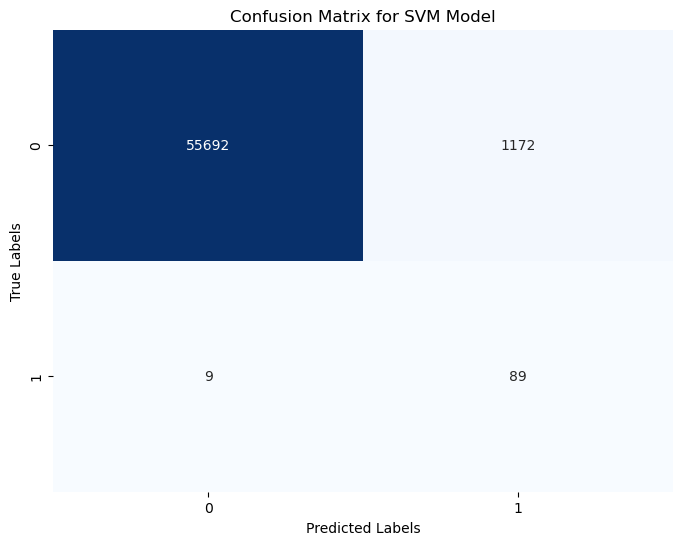

In [64]:
# Import necessary metrics from sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='weighted')  # Use 'binary' for binary classification
recall = recall_score(y_test, y_pred_svm, average='weighted')  # Use 'binary' for binary classification
f1 = f1_score(y_test, y_pred_svm, average='weighted')  # Use 'binary' for binary classification

# Print individual metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print comprehensive classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Create a confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for SVM Model')
plt.show()